<a href="https://colab.research.google.com/github/MySureStart/spring_2023_vail-HabibaShera/blob/main/Day_10/Regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

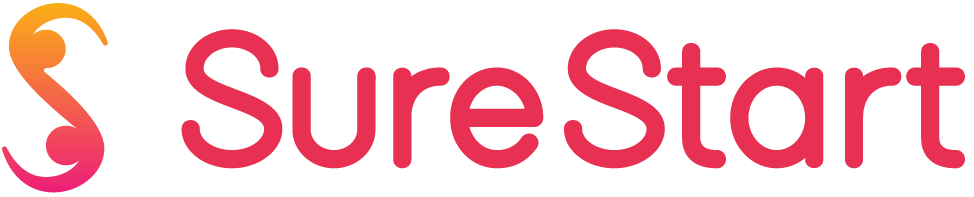

#Day 10 Objectives:
* To acquaint you with the problem of overfit models and to mitigate it with regularization

# Applying regularization

You may be familiar with Occam's Razor principle: given two explanations for something, the explanation most likely to be correct is the "simplest" one, the one that makes the least amount of assumptions. This also applies to the models learned by neural networks: given some training data and a network architecture, there are multiple sets of weights values (multiple models) that could explain the data, and simpler models are less likely to overfit than complex ones.

A "simple model" in this context is a model where the distribution of parameter values has less entropy (or a model with fewer parameters altogether, as we saw in the section above). Thus a common way to mitigate overfitting is to put constraints on the complexity of a network by forcing its weights only to take small values, which makes the distribution of weight values more "regular". This is called "weight regularization", and it is done by adding to the loss function of the network a cost associated with having large weights. This cost comes in two flavors:

L1 regularization, where the cost added is proportional to the absolute value of the weights coefficients (i.e. to what is called the "L1 norm" of the weights).

L2 regularization, where the cost added is proportional to the square of the value of the weights coefficients (i.e. to what is called the squared "L2 norm" of the weights). L2 regularization is also called weight decay in the context of neural networks. Don't let the different name confuse you: weight decay is mathematically the exact same as L2 regularization.

L1 regularization pushes weights towards exactly zero encouraging a sparse model. L2 regularization will penalize the weights parameters without making them sparse since the penalty goes to zero for small weights-one reason why L2 is more common.

In `tf.keras`, weight regularization is added by passing weight regularizer instances to layers as keyword arguments. Let's add L2 weight regularization now.


In [8]:
# Basic packages
import pandas as pd 
import numpy as np
import re
import collections
import matplotlib.pyplot as plt
from pathlib import Path

# Packages for data preparation
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder

import nltk

nltk.download('stopwords')

# Packages for modeling
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import regularizers

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [9]:
def remove_stopwords(input_text):
  stopwords_list = stopwords.words('english')
  # Some words which might indicate a certain sentiment are kept via a whitelist
  whitelist = ["n't", "not", "no"]
  words = input_text.split() 
  clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
  return " ".join(clean_words) 
#==================================================================
def remove_mentions(input_text):
  return re.sub(r'@\w+', '', input_text)
#==================================================================
def deep_model(model, X_train, y_train, X_valid, y_valid):
  model.compile(optimizer='rmsprop'
                  , loss='categorical_crossentropy'
                  , metrics=['accuracy'])
    
  history = model.fit(X_train
                       , y_train
                       , epochs=NB_START_EPOCHS
                       , batch_size=BATCH_SIZE
                       , validation_data=(X_valid, y_valid)
                       , verbose=1)
  return history
#==================================================================
def optimal_epoch(model_hist):
  min_epoch = np.argmin(model_hist.history['val_loss']) + 1
  print("Minimum validation loss reached in epoch {}".format(min_epoch))
  return min_epoch
 

In [10]:
NB_WORDS = 10000  # Parameter indicating the number of words we'll put in the dictionary
NB_START_EPOCHS = 20  # Number of epochs we usually start to train with
BATCH_SIZE = 512  # Size of the batches used in the mini-batch gradient descent
MAX_LEN = 20  # Maximum number of words in a sequence

In [11]:
root = Path('../content/')
input_path = root / 'input/' 
ouput_path = root / 'output/'
source_path = root / 'source/'

In [12]:
! gdown --id 1QFupRVBpstzf_D6NiFvYQIO-MPuiwG9u 
! mkdir input/ 
! mv Tweets.csv input/

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1QFupRVBpstzf_D6NiFvYQIO-MPuiwG9u
To: /content/Tweets.csv
100% 3.42M/3.42M [00:00<00:00, 198MB/s]


In [13]:
df = pd.read_csv(input_path / 'Tweets.csv')
df = df.reindex(np.random.permutation(df.index))  
df = df[['text', 'airline_sentiment']]
df.text = df.text.apply(remove_stopwords).apply(remove_mentions)

In [14]:
reg_model = models.Sequential()
reg_model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu', input_shape=(NB_WORDS,)))
reg_model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
reg_model.add(layers.Dense(3, activation='softmax'))
reg_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 64)                640064    
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 3)                 195       
                                                                 
Total params: 644,419
Trainable params: 644,419
Non-trainable params: 0
_________________________________________________________________


In [17]:
X_train, X_test, y_train, y_test = train_test_split(df.text, df.airline_sentiment, test_size=0.1, random_state=37)
print('# Train data samples:', X_train.shape[0])
print('# Test data samples:', X_test.shape[0])
assert X_train.shape[0] == y_train.shape[0]
assert X_test.shape[0] == y_test.shape[0]


tk = Tokenizer(num_words=NB_WORDS,
               filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~\t\n',
               lower=True,
               char_level=False,
               split=' ')
tk.fit_on_texts(X_train)


X_train_oh = tk.texts_to_matrix(X_train, mode='binary')
X_test_oh = tk.texts_to_matrix(X_test, mode='binary')

le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)
y_train_oh = to_categorical(y_train_le)
y_test_oh = to_categorical(y_test_le)

X_train_rest, X_valid, y_train_rest, y_valid = train_test_split(X_train_oh, y_train_oh, test_size=0.1, random_state=37)

assert X_valid.shape[0] == y_valid.shape[0]
assert X_train_rest.shape[0] == y_train_rest.shape[0]

# Train data samples: 13176
# Test data samples: 1464


In [18]:
reg_history = deep_model(reg_model, X_train_rest, y_train_rest, X_valid, y_valid)
reg_min = optimal_epoch(reg_history)

Epoch 1/20
24/24 [==============================] - 8s 48ms/step - loss: 1.0351 - accuracy: 0.6260 - val_loss: 0.8942 - val_accuracy: 0.6313
Epoch 2/20
24/24 [==============================] - 0s 20ms/step - loss: 0.8026 - accuracy: 0.7069 - val_loss: 0.7473 - val_accuracy: 0.7564
Epoch 3/20
24/24 [==============================] - 1s 25ms/step - loss: 0.6584 - accuracy: 0.8126 - val_loss: 0.6704 - val_accuracy: 0.7830
Epoch 4/20
24/24 [==============================] - 1s 23ms/step - loss: 0.5613 - accuracy: 0.8482 - val_loss: 0.6426 - val_accuracy: 0.7769
Epoch 5/20
24/24 [==============================] - 1s 26ms/step - loss: 0.4976 - accuracy: 0.8695 - val_loss: 0.6418 - val_accuracy: 0.7769
Epoch 6/20
24/24 [==============================] - 0s 20ms/step - loss: 0.4507 - accuracy: 0.8835 - val_loss: 0.6569 - val_accuracy: 0.7807
Epoch 7/20
24/24 [==============================] - 1s 24ms/step - loss: 0.4157 - accuracy: 0.8982 - val_loss: 0.6593 - val_accuracy: 0.7754
Epoch 8/20
24

In [22]:
base_model = models.Sequential()
base_model.add(layers.Dense(64, activation='relu', input_shape=(NB_WORDS,)))
base_model.add(layers.Dense(64, activation='relu'))
base_model.add(layers.Dense(3, activation='softmax'))
base_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 64)                640064    
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
 dense_8 (Dense)             (None, 3)                 195       
                                                                 
Total params: 644,419
Trainable params: 644,419
Non-trainable params: 0
_________________________________________________________________


In [23]:
base_history = deep_model(base_model, X_train_rest, y_train_rest, X_valid, y_valid)
base_min = optimal_epoch(base_history)

Epoch 1/20
24/24 [==============================] - 1s 28ms/step - loss: 0.8810 - accuracy: 0.6177 - val_loss: 0.7310 - val_accuracy: 0.6700
Epoch 2/20
24/24 [==============================] - 0s 17ms/step - loss: 0.6336 - accuracy: 0.7294 - val_loss: 0.5793 - val_accuracy: 0.7762
Epoch 3/20
24/24 [==============================] - 0s 17ms/step - loss: 0.4868 - accuracy: 0.8270 - val_loss: 0.5212 - val_accuracy: 0.7883
Epoch 4/20
24/24 [==============================] - 0s 16ms/step - loss: 0.3965 - accuracy: 0.8618 - val_loss: 0.5085 - val_accuracy: 0.7898
Epoch 5/20
24/24 [==============================] - 0s 16ms/step - loss: 0.3339 - accuracy: 0.8835 - val_loss: 0.5215 - val_accuracy: 0.7830
Epoch 6/20
24/24 [==============================] - 0s 18ms/step - loss: 0.2859 - accuracy: 0.9000 - val_loss: 0.5508 - val_accuracy: 0.7762
Epoch 7/20
24/24 [==============================] - 0s 16ms/step - loss: 0.2479 - accuracy: 0.9158 - val_loss: 0.5901 - val_accuracy: 0.7739
Epoch 8/20
24

For the regularized model we notice that it starts overfitting in the same epoch as the baseline model. However, the loss increases much slower afterwards.



In [19]:
def eval_metric(model, history, metric_name):
  metric = history.history[metric_name]
  val_metric = history.history['val_' + metric_name]

  e = range(1, NB_START_EPOCHS + 1)

  plt.plot(e, metric, 'bo', label='Train ' + metric_name)
  plt.plot(e, val_metric, 'b', label='Validation ' + metric_name)
  plt.xlabel('Epoch number')
  plt.ylabel(metric_name)
  plt.title('Comparing training and validation ' + metric_name + ' for ' + model.name)
  plt.legend()
  plt.show()
#==================================================================
def compare_models_by_metric(model_1, model_2, model_hist_1, model_hist_2, metric):
  metric_model_1 = model_hist_1.history[metric]
  metric_model_2 = model_hist_2.history[metric]

  e = range(1, NB_START_EPOCHS + 1)
    
  metrics_dict = {
        'acc' : 'Training Accuracy',
        'loss' : 'Training Loss',
        'val_acc' : 'Validation accuracy',
        'val_loss' : 'Validation loss'
    }
    
  metric_label = metrics_dict[metric]

  plt.plot(e, metric_model_1, 'bo', label=model_1.name)
  plt.plot(e, metric_model_2, 'b', label=model_2.name)
  plt.xlabel('Epoch number')
  plt.ylabel(metric_label)
  plt.title('Comparing ' + metric_label + ' between models')
  plt.legend()
  plt.show()   

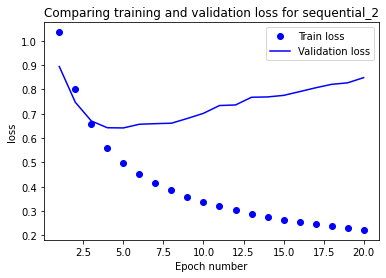

In [20]:
eval_metric(reg_model, reg_history, 'loss')

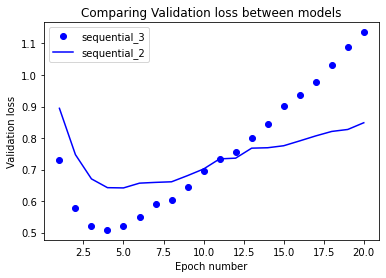

In [24]:
compare_models_by_metric(base_model, reg_model, base_history, reg_history, 'val_loss')

## Question 1

First identify (provide the name of) and then code the regularizer which is used in the following loss function:

$$cost = (\mathbf{y} - \mathbf{x}W)^2 + λ||W||$$

Let's assume $w = [-5, 4, -3, 2, 1]$

###  Answer 1

In [25]:
weights = [-5, 4, -3, 2, 1]

def l1_norm(weights):
    # Enter your code here
    reg = np.abs(weights)
    return reg

print(l1_norm(weights))

[5 4 3 2 1]


## Question 2

First identify (provide the name of) and then code the regularizer which is used in the following loss function:

$$cost = (\mathbf{y} - \mathbf{x}W)^2 + λ||W||_2^2$$

Let's assume $w = [-5, 4, -3, 2, 1]$

###  Answer 2

In [26]:
weights = [-5, 4, -3, 2, 1]

def l2_norm(weights):
    # Enter your code here
    reg = np.power(weights, 2)
    return reg

print(l2_norm(weights))

[25 16  9  4  1]


## Adding dropout layers
Add dropout
Dropout is one of the most effective and most commonly used regularization techniques for neural networks, developed by Hinton and his students at the University of Toronto.

The intuitive explanation for dropout is that because individual nodes in the network cannot rely on the output of the others, each node must output features that are useful on their own.

Dropout, applied to a layer, consists of randomly "dropping out" (i.e. set to zero) a number of output features of the layer during training. Let's say a given layer would normally have returned a vector [0.2, 0.5, 1.3, 0.8, 1.1] for a given input sample during training; after applying dropout, this vector will have a few zero entries distributed at random, e.g. [0, 0.5, 1.3, 0, 1.1].

The "dropout rate" is the fraction of the features that are being zeroed-out; it is usually set between 0.2 and 0.5. At test time, no units are dropped out, and instead the layer's output values are scaled down by a factor equal to the dropout rate, so as to balance for the fact that more units are active than at training time.

In `tf.keras` you can introduce dropout in a network via the Dropout layer, which gets applied to the output of layer right before.

Let's add two Dropout layers in our network to see how well they do at reducing overfitting:

In [27]:
drop_model = models.Sequential()
drop_model.add(layers.Dense(64, activation='relu', input_shape=(NB_WORDS,)))
drop_model.add(layers.Dropout(0.5))
drop_model.add(layers.Dense(64, activation='relu'))
drop_model.add(layers.Dropout(0.5))
drop_model.add(layers.Dense(3, activation='softmax'))
drop_model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 64)                640064    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_10 (Dense)            (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 3)                 195       
                                                                 
Total params: 644,419
Trainable params: 644,419
Non-trainable params: 0
_________________________________________________________________


In [28]:
drop_history = deep_model(drop_model, X_train_rest, y_train_rest, X_valid, y_valid)
drop_min = optimal_epoch(drop_history)

Epoch 1/20
24/24 [==============================] - 2s 32ms/step - loss: 0.8824 - accuracy: 0.6209 - val_loss: 0.7585 - val_accuracy: 0.6229
Epoch 2/20
24/24 [==============================] - 1s 21ms/step - loss: 0.7261 - accuracy: 0.6407 - val_loss: 0.6780 - val_accuracy: 0.6768
Epoch 3/20
24/24 [==============================] - 0s 19ms/step - loss: 0.6466 - accuracy: 0.7136 - val_loss: 0.6189 - val_accuracy: 0.7580
Epoch 4/20
24/24 [==============================] - 0s 21ms/step - loss: 0.5702 - accuracy: 0.7856 - val_loss: 0.5701 - val_accuracy: 0.7769
Epoch 5/20
24/24 [==============================] - 1s 21ms/step - loss: 0.5070 - accuracy: 0.8216 - val_loss: 0.5391 - val_accuracy: 0.7769
Epoch 6/20
24/24 [==============================] - 0s 18ms/step - loss: 0.4497 - accuracy: 0.8446 - val_loss: 0.5323 - val_accuracy: 0.7853
Epoch 7/20
24/24 [==============================] - 0s 16ms/step - loss: 0.4053 - accuracy: 0.8601 - val_loss: 0.5342 - val_accuracy: 0.7838
Epoch 8/20
24

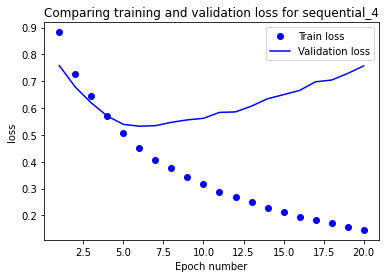

In [29]:
eval_metric(drop_model, drop_history, 'loss')


The model with dropout layers starts overfitting later than the baseline model. The loss also increases slower than the baseline model.



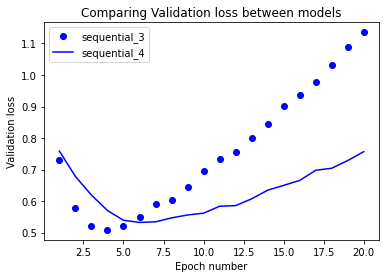

In [30]:
compare_models_by_metric(base_model, drop_model, base_history, drop_history, 'val_loss')


The model with the Dropout layers starts overfitting later. Compared to the baseline model the loss also remains much lower.



## Combined L2 + dropout

In [31]:
combined_model = tf.keras.Sequential([
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='relu', input_shape=(NB_WORDS,)),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(3)
])


In [32]:
combined_history = deep_model(combined_model, X_train_rest, y_train_rest, X_valid, y_valid)
combined_min = optimal_epoch(combined_history)

Epoch 1/20
24/24 [==============================] - 2s 31ms/step - loss: 1.4521 - accuracy: 0.1802 - val_loss: 1.0770 - val_accuracy: 0.0933
Epoch 2/20
24/24 [==============================] - 1s 21ms/step - loss: 5.1006 - accuracy: 0.0992 - val_loss: 7.3145 - val_accuracy: 0.0774
Epoch 3/20
24/24 [==============================] - 1s 22ms/step - loss: 6.2039 - accuracy: 0.0745 - val_loss: 10.0322 - val_accuracy: 0.0789
Epoch 4/20
24/24 [==============================] - 1s 22ms/step - loss: 7.6162 - accuracy: 0.0531 - val_loss: 8.9654 - val_accuracy: 0.0744
Epoch 5/20
24/24 [==============================] - 0s 20ms/step - loss: 7.9190 - accuracy: 0.0495 - val_loss: 9.8536 - val_accuracy: 0.0842
Epoch 6/20
24/24 [==============================] - 1s 22ms/step - loss: 9.9621 - accuracy: 0.0632 - val_loss: 10.4309 - val_accuracy: 0.0842
Epoch 7/20
24/24 [==============================] - 1s 21ms/step - loss: 6.3835 - accuracy: 0.0418 - val_loss: 11.6674 - val_accuracy: 0.0835
Epoch 8/20

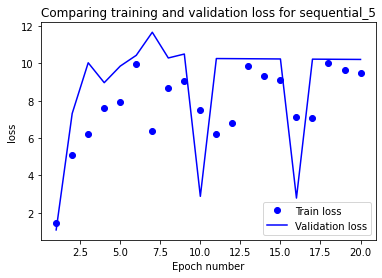

In [33]:
eval_metric(combined_model, combined_history, 'loss')


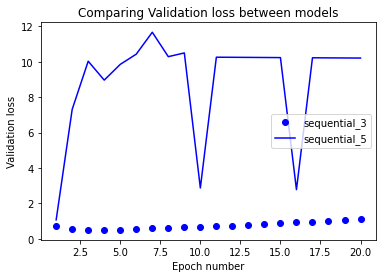

In [34]:
compare_models_by_metric(base_model, combined_model, base_history, combined_history, 'val_loss')


## Question 3

When does it make sense to add both L2 regularization and Dropout?

And what did doing so achieve in this case?


### Answer 3

When we observe that we have overfitting in our training, we can use regularization and dropout.

In our case, I observe that adding both L2 regularization and dropout doesn't affect on the result. I see that the loss is not stable at all in training and validation data and the accuracy decreased and reached 16%. It was 75 percent in the base model in validation data.

#Training on the full train data and evaluation on test dataAt first sight the reduced model seems to be the best model for generalization. But let's check that on the test set.

In [35]:
def test_model(model, X_train, y_train, X_test, y_test, epoch_stop):
  model.fit(X_train
              , y_train
              , epochs=epoch_stop
              , batch_size=BATCH_SIZE
              , verbose=1)
  results = model.evaluate(X_test, y_test)
  print()
  print('Test accuracy: {0:.2f}%'.format(results[1]*100))
  return results

In [36]:
base_results = test_model(base_model, X_train_oh, y_train_oh, X_test_oh, y_test_oh, base_min)


Epoch 1/4
26/26 [==============================] - 0s 15ms/step - loss: 0.1544 - accuracy: 0.9594
Epoch 2/4
26/26 [==============================] - 0s 14ms/step - loss: 0.1080 - accuracy: 0.9684
Epoch 3/4
26/26 [==============================] - 0s 15ms/step - loss: 0.0866 - accuracy: 0.9743
Epoch 4/4
46/46 [==============================] - 0s 3ms/step - loss: 0.9488 - accuracy: 0.7801

Test accuracy: 78.01%


In [37]:
reduced_model = models.Sequential()
reduced_model.add(layers.Dense(16, activation='relu', input_shape=(NB_WORDS,)))
reduced_model.add(layers.Dense(3, activation='softmax'))
reduced_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_17 (Dense)            (None, 16)                160016    
                                                                 
 dense_18 (Dense)            (None, 3)                 51        
                                                                 
Total params: 160,067
Trainable params: 160,067
Non-trainable params: 0
_________________________________________________________________


In [38]:
reduced_history = deep_model(reduced_model, X_train_rest, y_train_rest, X_valid, y_valid)
reduced_min = optimal_epoch(reduced_history)

Epoch 1/20
24/24 [==============================] - 1s 26ms/step - loss: 0.9453 - accuracy: 0.6316 - val_loss: 0.8448 - val_accuracy: 0.6419
Epoch 2/20
24/24 [==============================] - 0s 17ms/step - loss: 0.7827 - accuracy: 0.6545 - val_loss: 0.7494 - val_accuracy: 0.6844
Epoch 3/20
24/24 [==============================] - 0s 16ms/step - loss: 0.6958 - accuracy: 0.7011 - val_loss: 0.6878 - val_accuracy: 0.7086
Epoch 4/20
24/24 [==============================] - 0s 17ms/step - loss: 0.6304 - accuracy: 0.7407 - val_loss: 0.6406 - val_accuracy: 0.7382
Epoch 5/20
24/24 [==============================] - 0s 16ms/step - loss: 0.5770 - accuracy: 0.7783 - val_loss: 0.6048 - val_accuracy: 0.7587
Epoch 6/20
24/24 [==============================] - 0s 17ms/step - loss: 0.5332 - accuracy: 0.8082 - val_loss: 0.5766 - val_accuracy: 0.7747
Epoch 7/20
24/24 [==============================] - 0s 18ms/step - loss: 0.4963 - accuracy: 0.8312 - val_loss: 0.5553 - val_accuracy: 0.7747
Epoch 8/20
24

In [39]:
reduced_results = test_model(reduced_model, X_train_oh, y_train_oh, X_test_oh, y_test_oh, reduced_min)


Epoch 1/13
26/26 [==============================] - 0s 14ms/step - loss: 0.2905 - accuracy: 0.9005
Epoch 2/13
26/26 [==============================] - 0s 14ms/step - loss: 0.2797 - accuracy: 0.9051
Epoch 3/13
26/26 [==============================] - 0s 14ms/step - loss: 0.2698 - accuracy: 0.9082
Epoch 4/13
26/26 [==============================] - 0s 14ms/step - loss: 0.2606 - accuracy: 0.9101
Epoch 5/13
26/26 [==============================] - 0s 14ms/step - loss: 0.2518 - accuracy: 0.9142
Epoch 6/13
26/26 [==============================] - 0s 14ms/step - loss: 0.2435 - accuracy: 0.9174
Epoch 7/13
26/26 [==============================] - 0s 13ms/step - loss: 0.2356 - accuracy: 0.9204
Epoch 8/13
26/26 [==============================] - 0s 15ms/step - loss: 0.2282 - accuracy: 0.9233
Epoch 9/13
26/26 [==============================] - 0s 14ms/step - loss: 0.2212 - accuracy: 0.9265
Epoch 10/13
26/26 [==============================] - 0s 14ms/step - loss: 0.2145 - accuracy: 0.9288
Epoch 11/

In [40]:
reg_results = test_model(reg_model, X_train_oh, y_train_oh, X_test_oh, y_test_oh, reg_min)


Epoch 1/5
26/26 [==============================] - 0s 14ms/step - loss: 0.2821 - accuracy: 0.9481
Epoch 2/5
26/26 [==============================] - 0s 14ms/step - loss: 0.2515 - accuracy: 0.9570
Epoch 3/5
26/26 [==============================] - 0s 17ms/step - loss: 0.2369 - accuracy: 0.9599
Epoch 4/5
26/26 [==============================] - 0s 16ms/step - loss: 0.2256 - accuracy: 0.9671
Epoch 5/5
46/46 [==============================] - 0s 3ms/step - loss: 0.7323 - accuracy: 0.7855

Test accuracy: 78.55%


In [41]:
drop_results = test_model(drop_model, X_train_oh, y_train_oh, X_test_oh, y_test_oh, drop_min)


Epoch 1/6
26/26 [==============================] - 0s 15ms/step - loss: 0.2082 - accuracy: 0.9363
Epoch 2/6
26/26 [==============================] - 0s 14ms/step - loss: 0.1838 - accuracy: 0.9415
Epoch 3/6
26/26 [==============================] - 0s 14ms/step - loss: 0.1704 - accuracy: 0.9482
Epoch 4/6
26/26 [==============================] - 0s 15ms/step - loss: 0.1585 - accuracy: 0.9471
Epoch 5/6
26/26 [==============================] - 0s 14ms/step - loss: 0.1407 - accuracy: 0.9552
Epoch 6/6
46/46 [==============================] - 0s 3ms/step - loss: 0.7345 - accuracy: 0.8067

Test accuracy: 80.67%


# Handling Underfitting
* In a general situation, the best strategy is to increase the model complexity by either increasing the number of parameters of your deep learning model or the order of your model. Underfitting is due to the model being simpler than needed. It fails to capture the patterns in the data. Increasing the model complexity will lead to improvement in training performance. If we use a large enough model it can even achieve a training error of zero i.e. the model will memorize the data and suffer from over-fitting. The goal is to hit the optimal sweet spot.
* Try to train the model for more epochs. Ensure that the loss is decreasing gradually over the course of the training. Otherwise, it is highly likely that there is some kind of bug or problem in the training code/logic itself.
* If you aren’t shuffling the data after every epoch, it can harm the model performance. Ensuring that you are shuffling the data is a good check to perform at this point.

#Conclusion
To recap: here are the most common ways to prevent overfitting in neural networks:

* Get more training data.
* Reduce the capacity of the network.
* Add weight regularization.
* Add dropout.

Two important approaches not covered in this guide are:

* data-augmentation
* batch normalization

Remember that each method can help on its own, but often combining them can be even more effective.

here are the ways to prevent underfitting

* Get more training data.
* Increase the size or number of parameters in the model.
* Increase the complexity of the model.
* Increasing the training time, until cost function is minimised.


# Bonus content - Visualizing L2 regularization


In [42]:
import numpy as np
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
import warnings
warnings.filterwarnings('ignore')
import itertools

In [43]:
def plot_contour(f, x1bound, x2bound, resolution, ax):
    x1range = np.linspace(x1bound[0], x1bound[1], resolution)
    x2range = np.linspace(x2bound[0], x2bound[1], resolution)
    xg, yg = np.meshgrid(x1range, x2range)
    zg = np.zeros_like(xg)
    for i,j in itertools.product(range(resolution), range(resolution)):
        zg[i,j] = f([xg[i,j], yg[i,j]])
    ax.contour(xg, yg, zg, 100)
    return ax

Let's create a toy data:

In [44]:
N = 20
x = np.random.rand(N) * 10
y = -4*x + 10 + 2*np.random.randn(N)

visualize the regularized **cost function** 

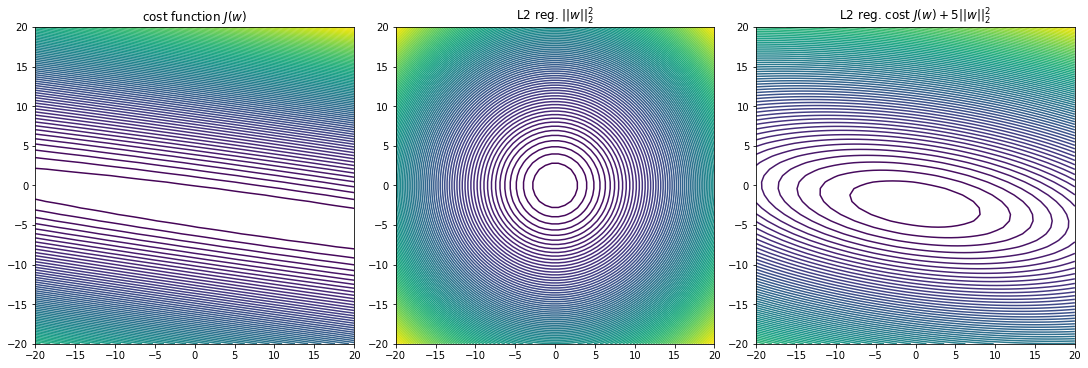

In [45]:
cost = lambda w: .5*np.mean((w[0] + w[1]*x - y)**2)
l2_penalty = lambda w: np.dot(w,w)/2
cost_plus_l2 = lambda w: cost(w) + 5*l2_penalty(w)

fig, axes = plt.subplots(ncols=3, nrows=1, constrained_layout=True, figsize=(15, 5))
plot_contour(cost, [-20,20], [-20,20], 50, axes[0])
axes[0].set_title(r'cost function $J(w)$')
plot_contour(l2_penalty, [-20,20], [-20,20], 50, axes[1])
axes[1].set_title(r'L2 reg. $||w||_2^2$')
plot_contour(cost_plus_l2, [-20,20], [-20,20], 50, axes[2])
axes[2].set_title(r'L2 reg. cost $J(w) + 5 ||w||_2^2$')
plt.show()

## Bonus question: Plot the same for L1 regularization 

### Answer 

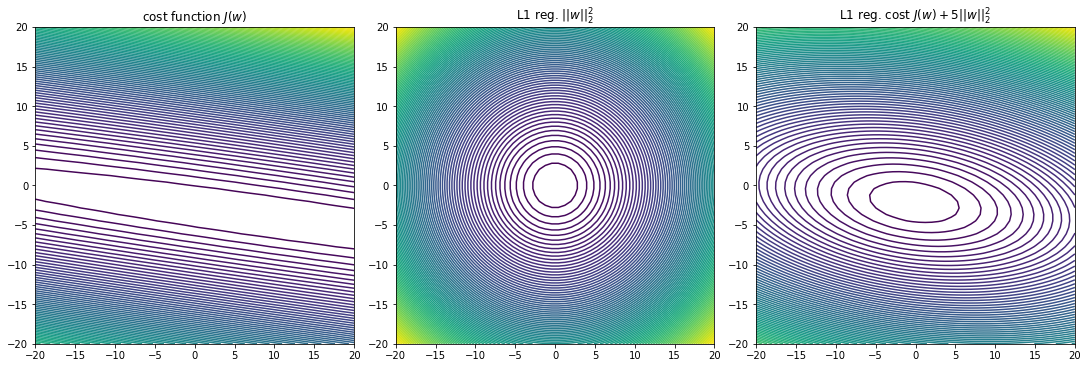

In [47]:
cost = lambda w: .5*np.mean((w[0] + w[1]*x - y)**2)
l1_penalty = lambda w: np.dot(w, w)
cost_plus_l2 = lambda w: cost(w) + 5*l1_penalty(w)

fig, axes = plt.subplots(ncols=3, nrows=1, constrained_layout=True, figsize=(15, 5))
plot_contour(cost, [-20,20], [-20,20], 50, axes[0])
axes[0].set_title(r'cost function $J(w)$')
plot_contour(l1_penalty, [-20,20], [-20,20], 50, axes[1])
axes[1].set_title(r'L1 reg. $||w||_2^2$')
plot_contour(cost_plus_l2, [-20,20], [-20,20], 50, axes[2])
axes[2].set_title(r'L1 reg. cost $J(w) + 5 ||w||_2^2$')
plt.show()

## Bonus Question 2
After looking at the visualization to what the L1 and L2 normalizations, how do they help while training?

\<*Type your answer here*\>

# **Upload this Day 9 Colab Notebook to your Github repository under "Day 9" folder. Also add your *Reflection* on today's learning in README.md**